In [4]:
import numpy as np
# Plotting libraries
import matplotlib.pylab as plt
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline
# This enables high resolution PNGs.
%config InlineBackend.figure_formats = {'png', 'svg'}
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt

from egttools.analytical import replicator_equation
from egttools.utils import find_saddle_type_and_gradient_direction
from egttools.plotting import plot_gradient
from egttools.analytical import StochDynamics
from egttools.analytical import replicator_equation
from egttools.utils import find_saddle_type_and_gradient_direction
from egttools.plotting import plot_gradient

In [55]:
import numpy as np

cost = 2

actions = np.asarray([cost, 0])


# Let's estimate the payoffs through simulation

def always_defect(prev_contribution_group, threshold, t):
    return actions[1]


def rm(prev_contribution_group, threshold, t):
    """
    If prev_donations >= threshold -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= threshold:
        return actions[0]  # coop
    else:
        return actions[1]  # defect


def npd(type1, type2, k, group_size, F, threshold, rounds):
    """
    Simulates a classical CRD (no timing uncertainty).
    :param F:
    :param cost:
    :param type1: [int] index of strategy 1
    :param type2: [int] index of strategy 2
    :param k: [int] number of group members adopting strategy 1
    :param group_size: [int] group size
    :param threshold: [int]
    :param r: [float] risk
    :param rounds: [int] total number of rounds
    :param endowment: [int] private endowment
    :return: [numpy.array] the payoffs of each strategy
    """
    payoffs = np.array([0, 0])

    if type1 == type2:  # all members of the group adopt the same strategy
        prev_contrib = group_size
        for i in range(rounds):
            don = type1(prev_contrib, threshold, i)

            #if payoffs[0] >= don1: #if endowment
            if don > 0:  # all coop
                payoffs[0] += ((prev_contrib * don * F) / group_size) - cost
                payoffs[1] += ((prev_contrib * don * F) / group_size) - cost

            # all defect, can return directly
            else:
                payoffs[0] += (prev_contrib * don * F) / group_size
                payoffs[1] += (prev_contrib * don * F) / group_size

    else:
        prev_contrib = k
        for i in range(rounds):  # the members of the group adopt different strategies
            don1 = type1(prev_contrib, threshold, i)
            don2 = type2(prev_contrib, threshold, i)
            
            don = max(don1,don2)
            
            # if payoffs[0] >= don1: if endowment
            payoffs[0] += ((prev_contrib * don * F) / group_size) - don1  # coop

            # if payoffs[1] >= don2: if endowment
            payoffs[1] += ((prev_contrib * don * F) / group_size) - don2  # defect
    return payoffs


class EstimatePayoffsNPD(object):
    strategies = ['RM','AL_DEFECT']
    strategies_caller = [rm,always_defect]
    ns = len(strategies)

    @staticmethod
    def estimate_payoff(invader, resident, group_size, F, threshold, rounds, iterations=100):
        """
        Estimates the payoff for invader and resident strategies,
        for the classical CRD.
        :param cost:
        :param F:
        :param invader: [int] index of the invading strategy
        :param resident: [int] index of the resident strategy
        :param group_size: [int] group size
        :param threshold: [int] contribution threshold for the conditional strategies
        :param r: [float] risk
        :param rounds: [int] number of rounds
        :param w: parameter not used
        :param iterations: [int] number of iterations used to average the game results
               (only relevant for stochastic results)
        :return: [lambda] function that returns the payoff of a crd group for each possible
                configuration of invader and resident strategies
        """
        payoffs = []
        for i in range(1, int(group_size) + 1):
            avg = 0.
            for _ in range(iterations):
                avg += npd(invader, resident, i, group_size, F, threshold, rounds)[0]
            payoffs.append(avg / float(iterations))

        # k is the number of invaders and z a dummy parameter
        return lambda k, z: payoffs[int(k) - 1]

    @staticmethod
    def estimate_payoffs(group_size, F, threshold, m0,
                         iterations=1000, save_name=None):
        """
        Estimates the payoffs of each strategy when playing against another.
        :param cost:
        :param F:
        :param group_size: [int] group size
        :param threshold: [int] contribution threshold for the conditional strategies
        :param r: [float] risk
        :param m0: [int] minimum number of rounds
        :param w: [float] probability that the game will and after the minimum number of rounds
        :param iterations: [int] number of iterations used to average the game results
        :param save_name: [string] name/path of file to save results, if None, the results are not saved
        :return: [numpy.array] the estimated payoffs
        """

        estimate = EstimatePayoffsNPD.estimate_payoff

        payoffs = np.asarray([[estimate(i, j, group_size, F, threshold, m0, iterations)
                                   for j in EstimatePayoffsNPD.strategies_caller] for i in
                                  EstimatePayoffsNPD.strategies_caller])

        return payoffs

In [77]:
nb_strategies = 2; Z = 100; N = 5;
beta = 1
test=np.array([
    [payoffs[0][0](1,100),payoffs[0][1](1,100)],
    [payoffs[1][0](1,100),payoffs[1][1](1,100)]
])
print(test)
evolver= StochDynamics(nb_strategies, test, Z)
evolver.mu = 0
stationary_SML = evolver.calculate_stationary_distribution(beta)
transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
print(fixation_probabilities)
print(stationary_distribution)

[[60.  0.]
 [ 1.  0.]]
[[ 0.          0.        ]
 [36.01138216  0.        ]]
[1. 0.]


1


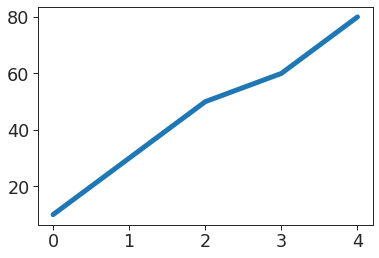

2


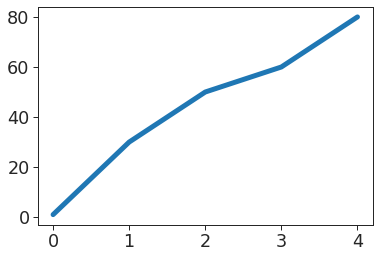

3


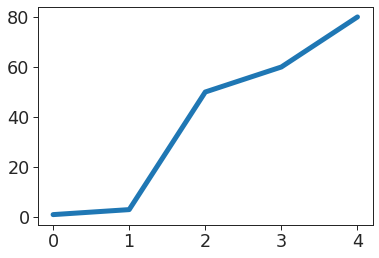

4


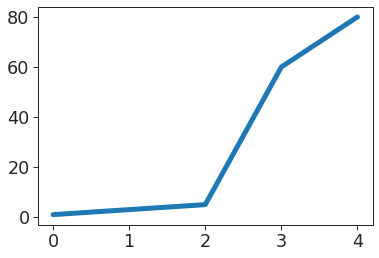

5


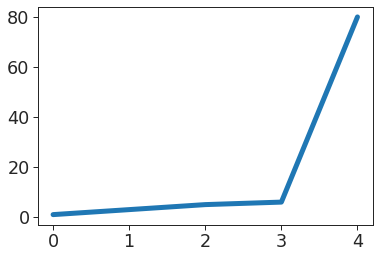

In [76]:
R=(1-0.9)**-1
c=2
F=4.25
N=5
estimateM1AD = EstimatePayoffsNPD()
for M in range(5):
    print(M+1)
    payoffs=estimateM1AD.estimate_payoffs(N, F, (M+1), round(R),100)
    ev=[]
    for i in range(N):
        ev.append(payoffs[1][0](i+1,N))
#0 is RM and 1 is AD
    plt.plot(ev)
    plt.show()

In [90]:
estimateM1AD = EstimatePayoffsNPD()
payoffs=estimateM1AD.estimate_payoffs(N, F, 3, round(R),100)


In [37]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
old_err_state = np.seterr(divide='raise')
plt.rcParams['svg.fonttype'] = 'none'

from egttools.analytical.sed_analytical import StochDynamics
flatten = lambda l: [item for sublist in l for item in sublist]

In [95]:
Z = 100
N = 5       # group size
beta = 1.   # We choose this beta after exploring its effects, and finding that if offers the best fit
mu = 0.0
drift = 1/float(Z)
iterations = 1000

sd = StochDynamics(EstimatePayoffsNPD.ns, payoffs, Z, N, mu=mu)
p_stationary_nu = sd.calculate_stationary_distribution(beta)
print(p_stationary_nu)

[1. 0.]


In [92]:
nb_strategies = 2; Z = 100; N = 5;
beta = 1
test=np.array([
    [payoffs[0][0](1,100),payoffs[0][1](1,100)],
    [payoffs[1][0](1,100),payoffs[1][1](1,100)]
])
print(test)
evolver= StochDynamics(nb_strategies, payoffs, Z,N)
evolver.mu = 0
stationary_SML = evolver.calculate_stationary_distribution(beta)
transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
print(fixation_probabilities)
print(stationary_distribution)

[[60.  0.]
 [ 1.  0.]]
[[0. 0.]
 [0. 0.]]
[1. 0.]


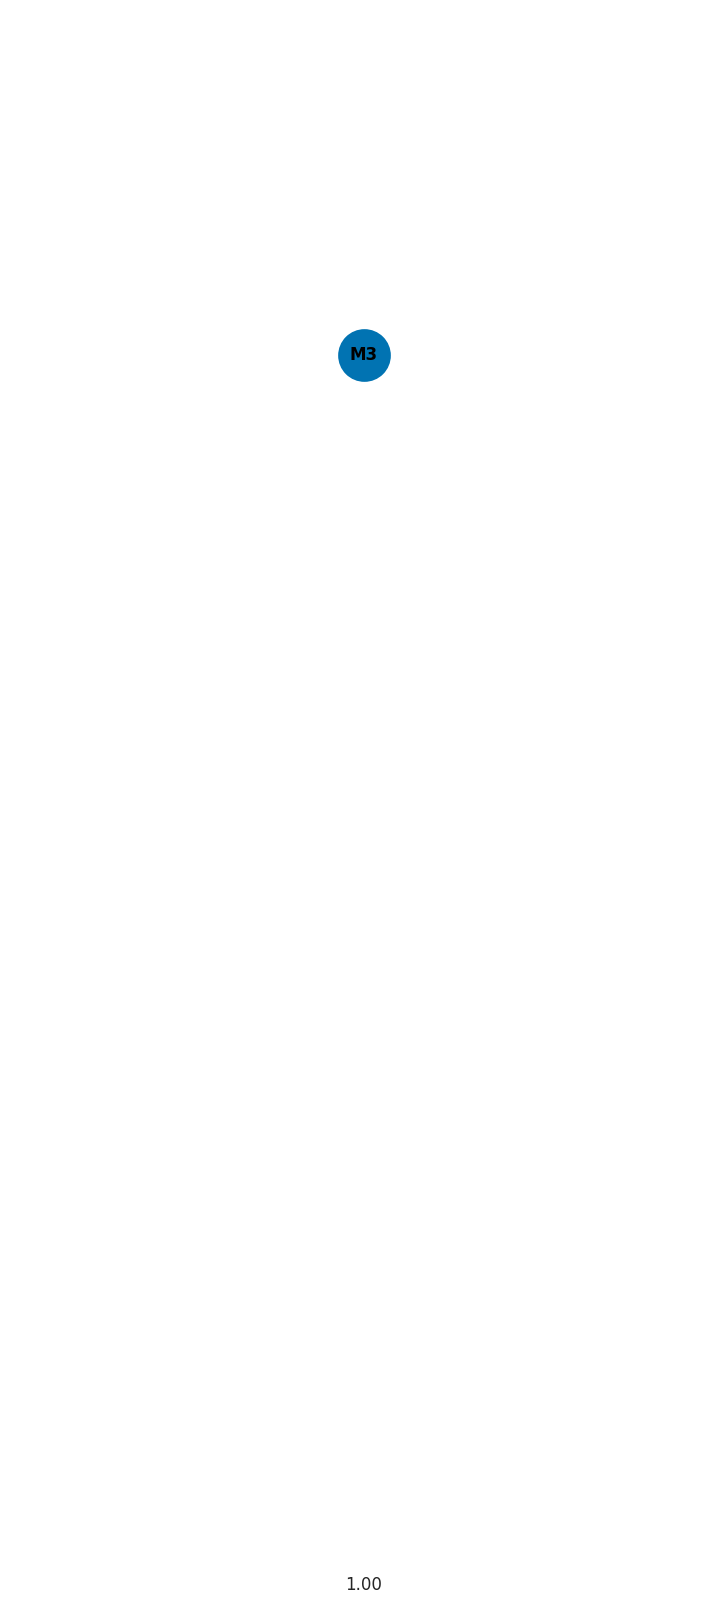

In [93]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
G = egt.plotting.draw_stationary_distribution(["M3","AD"],
                                              1/Z, fixation_probabilities, stationary_distribution,
                                              node_size=600,
                                              font_size_node_labels=8,
                                              font_size_edge_labels=8,
                                              font_size_sd_labels=8,
                                              edge_width=1,
                                              min_strategy_frequency=0.00001,
                                              ax=ax)
plt.axis('off')
plt.show() # display

In [30]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 5.0,
                                              "lines.markersize": 8,
                                              "lines.markeredgewidth": 10,
                                             })

s1 = polarisation[:, 0]
s2 = s1 + polarisation[:, 1]
s3 = s2 + polarisation[:, 2]

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
plt.bar(x=[1, 2, 3], height=s3, color="#ef8a62", label="$C<F$")
plt.bar(x=[1, 2, 3], height=s2, color="#f7f7f7", label="$C=F$")
plt.bar(x=[1, 2, 3], height=s1, color="#67a9cf", label="$C>F$")
ax.set_position([0.1,0.1,0.6,0.9])
L = plt.legend(bbox_to_anchor=(1.35, 1.), loc='upper right', borderaxespad=0., frameon=False)
ax.set_ylabel("Fraction of players")
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["NU", "LU", "HU"])
# plt.yticks(range(0, 1, 21))
ax.set_ylim(0, 1)
ax.tick_params(axis="y", direction="in", pad=8)
ax.tick_params(axis="y", which="minor", direction="in")
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis="x", length=5, pad=8)

sns.despine(offset=0, bottom=False)

NameError: name 'polarisation' is not defined